# W266 Final Project Modeling
## 1. Setup

In [1]:
# Import libraries
!pip install gensim==3.8.3 --quiet
!pip install tensorflow tensorflow-text --quiet

from google.colab import files
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_text as tf_text
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.data import find
import gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.1 MB/s eta 0:00:00


In [2]:
# Read the data
uploaded = files.upload()

Saving top_30_emotes.csv to top_30_emotes.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))
df.rename(columns={"label": "label_name"}, inplace=True)
df.head(5)

<ipython-input-3-5366ad058dd5>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))


,commenter_id,commenter_name,user_type,message_time,message_type,streamer,video_date,video_id,message_length,message,input,label_name
0,23261972.0,qrass,User,2023-03-11T18:05:21.218Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,3,no skipper stream Sadge,no skipper stream,Sadge
1,160455408.0,moby_drip,User,2023-03-11T18:05:42.405Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,3 second skippy stream Pog,3 second skippy stream,Pog
2,39897326.0,charmiee,User,2023-03-11T18:06:01.633Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,8,u got the wrong channel at first mate LUL,u got the wrong channel at first mate,LUL
3,115717981.0,just__ok,User,2023-03-11T18:06:31.622Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,Sadge not at streamer awards,not at streamer awards,Sadge
4,28841240.0,Karaszan,User,2023-03-11T18:06:53.793Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,10,Is it real this time? @sodapoppin :D No Stream...,Is it real this time? @sodapoppin :D No Stream...,Sadge


In [4]:
df.groupby('streamer')['video_id'].nunique().sort_values(ascending=False)[:10]

streamer
esl_csgo           18
xqc                18
hasanabi           17
fextralife         17
rainbow6           16
forsen             16
nmplol             16
clix               16
tsm_imperialhal    16
summit1g           15
Name: video_id, dtype: int64

In [5]:
streamer_counts = df[['streamer']].groupby(['streamer'])['streamer'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
print('Number of streamers:', len(streamer_counts))
print('Average messages per streamer:', streamer_counts["count"].mean())
streamer_counts

Number of streamers: 93
Average messages per streamer: 9234.086021505376


,streamer,count
27,forsen,92871
43,lec,82374
33,hasanabi,66891
88,xqc,53476
38,kaicenat,52015
...,...,...
20,eamaddennfl,89
84,unboxholics,88
17,cxmmunity,59
5,brawlhalla,32


In [6]:
emote_counts = df[['label_name']].groupby(['label_name'])['label_name'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
emote_counts

,label_name,count
9,KEKW,184087
12,LUL,177796
18,Pog,61591
22,Sadge,46814
7,FeelsBadMan,36106
10,Kappa,28720
8,FeelsGoodMan,28670
16,PepeLaugh,26186
26,YEP,22640
20,PogU,20375


In [7]:
df = pd.merge(df, emote_counts, on="label_name")

In [8]:
# Lower case input column
df['input'] = df['input'].str.lower()

In [64]:
# String index the label names
le = LabelEncoder()
df['label'] = le.fit_transform(df['label_name'])

# You can reverse this encoding: le.inverse_transform([9, 10, 1, 2])
# range(30)
target_names = le.inverse_transform(range(30))
print(target_names)

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [37]:
messages = df.input
labels = df.label
# Split into train & test
train_texts, test_texts, train_labels, test_labels = train_test_split(messages, labels, test_size=0.1, random_state=123)
print(len(train_texts))
print(len(test_texts))

772893
85877


In [11]:
train_texts[:5]

331858    beefr_ lost 1 points in roulette and now has 4...
718472    my first spam  my first spam  my first spam  m...
616267                                         born by it. 
355321                                     didnt wash hands
487140    look at our doctors dawg, we definitely not ma...
Name: input, dtype: object

In [12]:
train_labels[:5]

331858     7
718472     8
616267    26
355321     5
487140     9
Name: label, dtype: int64

Let's explicitly set aside part of our training set for validation purposes.



In [38]:
# Validation split is about 90/10 split
valid_texts = train_texts[700000:] 
valid_labels = train_labels[700000:]
train_texts = train_texts[:700000]
train_labels = train_labels[:700000]

print(len(train_texts)) # Always 500,000
print(len(valid_texts)) # 72893 until we change emotes

700000
72893


In [39]:
# Get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

## 2. Baseline Model (Majority Class)

In [15]:
majority = train_labels.mode()[0]
print('Majority class:', majority)
print('Majority class name:', le.inverse_transform([majority]))
# train_labels.value_counts()

Majority class: 9
Majority class name: ['KEKW']


In [16]:
# Predict for train
test_predictions = np.empty(len(test_texts))
test_predictions.fill(majority)

In [17]:
# Compare the first 5 predictions
test_compare = pd.DataFrame(test_labels.copy())
test_compare['prediction'] = test_predictions.astype(int)
test_compare.head(5)

,label,prediction
420784,9,9
341594,7,9
479490,9,9
281769,12,9
578999,16,9


In [18]:
print(le.inverse_transform(range(30)))

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [19]:
print(classification_report(test_labels, test_predictions))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       973
           1       0.00      0.00      0.00       482
           2       0.00      0.00      0.00       512
           3       0.00      0.00      0.00      1820
           4       0.00      0.00      0.00      1409
           5       0.00      0.00      0.00       829
           6       0.00      0.00      0.00       713
           7       0.00      0.00      0.00      3602
           8       0.00      0.00      0.00      2823
           9       0.22      1.00      0.36     18593
          10       0.00      0.00      0.00      2832
          11       0.00      0.00      0.00      1107
          12       0.00      0.00      0.00     17772
          13       0.00      0.00      0.00      1796
          14       0.00      0.00      0.00      1679
          15       0.00      0.00      0.00       923
          16       0.00      0.00      0.00      2627
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Model 1: LSTM

In [20]:
# Get word2vec model from nltk
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

len(model.vocab)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


43981

In [40]:
# Build embedding matrix and vocab dictionary
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.vocab.keys()):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [41]:
embedding_matrix.shape

(43982, 300)

In [42]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
test_tokens = tokenizer.tokenize(test_texts)

In [43]:
train_tokens[0]

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'beefr_', b'lost', b'1', b'points', b'in', b'roulette', b'and',
       b'now', b'has', b'470206', b'points!'], dtype=object)>

In [44]:
MAX_SEQUENCE_LENGTH = 32

In [45]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [ ]:
# num_train_examples = 200000
# num_test_examples = 50000

# train_tokens = train_tokens[:num_train_examples]
# test_tokens = test_tokens[:num_test_examples]

# train_labels = train_labels[:num_train_examples] 
# test_labels = test_labels[:num_test_examples]

In [46]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Examples processed:  55000
Examples processed:  60000
Examples processed:  65000
Examples processed:  70000
Examples processed:  75000
Examples processed:  80000
Examples processed:  85000
Examples processed:  90000
Examples processed:  95000
Examples processed:  100000
Examples processed:  105000
Examples processed:  110000
Examples processed:  115000
Examples processed:  120000
Examples processed:  125000
Examples processed:  130000
Examples processed:  135000
Examples processed:  140000
Examples processed:  145000
Examples processed:  150000
Examples processed:  155000
Examples processed:  160000
Examples processed:  165000
Examples processed:  170000
Examples processed:  175000
Examples processe

In [47]:
train_tokens[:5]

<tf.RaggedTensor [[b'beefr_', b'lost', b'1', b'points', b'in', b'roulette', b'and', b'now',
  b'has', b'470206', b'points!']                                          ,
 [b'my', b'first', b'spam', b'my', b'first', b'spam', b'my', b'first',
  b'spam', b'my', b'first', b'spam', b'my', b'first', b'spam', b'my',
  b'first', b'spam', b'my', b'first', b'spam', b'\xf3\xa0\x80\x80']   ,
 [b'born', b'by', b'it.'], [b'didnt', b'wash', b'hands'],
 [b'look', b'at', b'our', b'doctors', b'dawg,', b'we', b'definitely',
  b'not', b'making', b'it', b'through', b'the', b'surgery']          ]>

In [48]:
train_input[:5]

array([[43981, 32183, 31066, 16764, 16915,  2370, 43981,  3638,   524,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981],
       [19334,  6416, 43981, 19334,  6416, 43981, 19334,  6416, 43981,
        19334,  6416, 43981, 19334,  6416, 43981, 19334,  6416, 43981,
        19334,  6416, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 4398

In [49]:
train_labels[:5]

array([ 7,  8, 26,  5,  9])

In [50]:
from tensorflow.keras.layers import Embedding

def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(30, activation='softmax')(last_hidden_output) # Change to numclasses (30)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 'categorical_crossentropy'?
                      metrics=['accuracy'])
    return rnn_model

In [51]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)


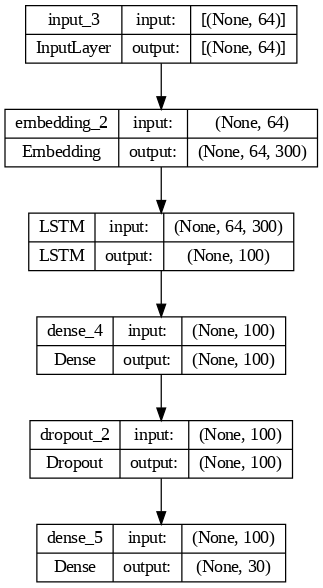

In [52]:
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [36]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
6250/6250 [==============================] - 46s 5ms/step - loss: 2.3366 - accuracy: 0.3149 - val_loss: 2.1969 - val_accuracy: 0.3452
Epoch 2/5
6250/6250 [==============================] - 32s 5ms/step - loss: 2.1843 - accuracy: 0.3484 - val_loss: 2.1252 - val_accuracy: 0.3597
Epoch 3/5
6250/6250 [==============================] - 32s 5ms/step - loss: 2.1245 - accuracy: 0.3623 - val_loss: 2.0872 - val_accuracy: 0.3660
Epoch 4/5
6250/6250 [==============================] - 31s 5ms/step - loss: 2.0843 - accuracy: 0.3715 - val_loss: 2.0621 - val_accuracy: 0.3750
Epoch 5/5
6250/6250 [==============================] - 33s 5ms/step - loss: 2.0510 - accuracy: 0.3797 - val_loss: 2.0438 - val_accuracy: 0.3789


In [54]:
test_predictions = rnn_model.predict(test_input)

2684/2684 [==============================] - 9s 3ms/step


In [56]:
test_predictions

array([[0.00411586, 0.00137457, 0.00578469, ..., 0.00145681, 0.00229366,
        0.00521976],
       [0.0089571 , 0.00351915, 0.00831598, ..., 0.00336955, 0.0041148 ,
        0.00663385],
       [0.01298821, 0.01371118, 0.00918506, ..., 0.00916692, 0.01933987,
        0.01263883],
       ...,
       [0.00164857, 0.00262682, 0.00159281, ..., 0.00034964, 0.00306522,
        0.00352633],
       [0.00420979, 0.00105802, 0.0052815 , ..., 0.00165647, 0.00219071,
        0.00491476],
       [0.01773485, 0.00756231, 0.0092044 , ..., 0.00183714, 0.00348253,
        0.00377581]], dtype=float32)

In [57]:
# Get the highest probability in the distribution for each prediction
test_predictions = tf.argmax(test_predictions, axis=-1)

<tf.Tensor: shape=(85877,), dtype=int64, numpy=array([ 9,  9, 12, ..., 22,  9, 12])>

In [58]:
print(classification_report(test_labels, test_predictions.numpy(), target_names=target_names))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.64      0.48      0.55       973
           1       0.84      0.11      0.19       482
           2       0.00      0.00      0.00       512
           3       0.47      0.22      0.30      1820
           4       0.00      0.00      0.00      1409
           5       0.34      0.03      0.05       829
           6       0.61      0.16      0.25       713
           7       0.95      0.58      0.72      3602
           8       0.88      0.74      0.80      2823
           9       0.27      0.77      0.40     18593
          10       0.00      0.00      0.00      2832
          11       0.00      0.00      0.00      1107
          12       0.30      0.27      0.28     17772
          13       1.00      0.97      0.98      1796
          14       0.00      0.00      0.00      1679
          15       0.00      0.00      0.00       923
          16       0.72      0.20      0.31      2627
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(220.72222222222223, 0.5, 'True')

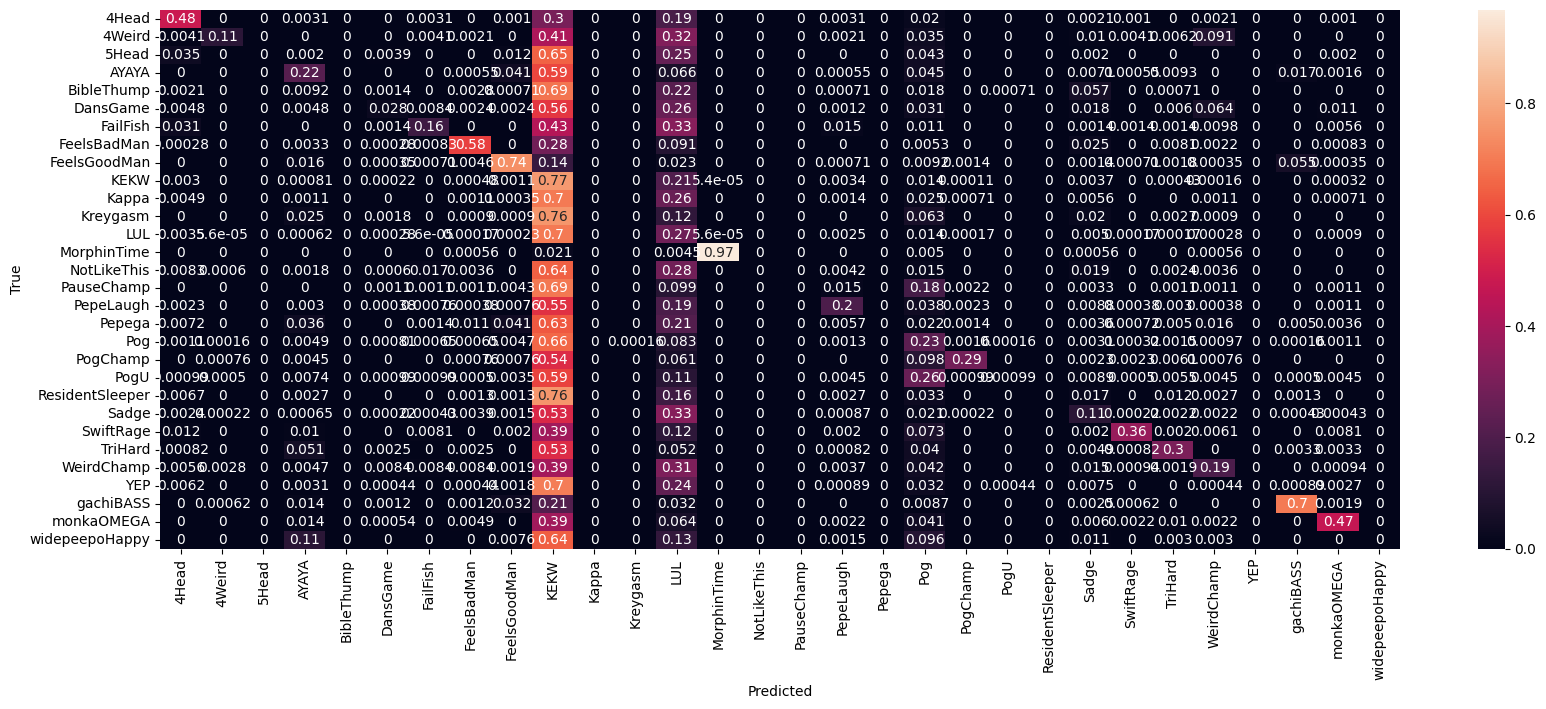

In [65]:
cm = tf.math.confusion_matrix(test_labels, test_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")